# Problem Statement

We are given small image patches of pathology scans and the goal of this notebook is to create a model that can accurately identify which images contains metastatic cancer or not. 

 # Data

We are given 96x96 RGB channel of pathology scans from a large digital image. The center 32x32 image contains the information one whether metastatic cancer is present or not.

|Description|Value|
|---|---|
|Size|96x96|
|Channel|RGB|
|Image Format|TIF|

Data Source: PCam

# Packages

In [4]:
import os
import shutil
import glob

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Deep Learning packages
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout, Input
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.densenet import DenseNet201

import tensorflow_addons as tfa

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

#### Global variables

In [2]:
TRAIN_DIRECTORY = r'/kaggle/input/histopathologic-cancer-detection/train/'
TEST_DIRECTORY = r'/kaggle/input/histopathologic-cancer-detection/test/'
WORKING_DIRECTORY = r'/kaggle/working/'

# EDA

In [3]:
# import the master file of data 
train_labels_path = r'/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
train_labels = pd.read_csv(train_labels_path)
train_labels.head()

# Test set
test = pd.DataFrame()
test['filename'] = glob.glob('/kaggle/input/histopathologic-cancer-detection/test/*.tif')
test['id'] = test['filename'].apply(lambda x: x.split('/')[-1][:-4])

In [5]:
# Check the total number of training samples 
total_sample = train_labels.shape[0]
print(f'Total Sample: {total_sample:,}')

# Check for Duplicates
dupe_count = total_sample - train_labels['id'].drop_duplicates().shape[0]
print(f'Number of duplicates: {dupe_count}')

# Check for missing images 
null_count = train_labels.isnull().sum()[0]
print(f'Null Value Counts: {null_count}')

Total Sample: 220,025
Number of duplicates: 0
Null Value Counts: 0


Although the problem statement initially said there should not be any duplicates in the subset of data, we check manually to ensure there is not duplicates. As well from the above we see our data is fully populated and there are no missing id or labels

In [5]:
# Functions to extract the image and their r,g,b data 
def get_image(path): 
    return PIL.Image.open(path)
def get_pixel(image):
    '''
    Gets the red,green,blue split in numpy array format 
    '''
    return np.array([np.array(x) for x in img.split()])

# First visualize what some of our data looks like
def plot_images(image_path_list, title=None): 
    n = len(image_path_list)
    
    fig, axs = plt.subplots(1,n,figsize=(n*2,n*2*.75))

    # Plot metastatic and non metastatic images
    for i in range(n):
        # Plot images 
        axs[i].imshow(get_image(os.path.join(TRAIN_DIRECTORY,image_path_list[i])))
        
    # Remove y and x axis 
    for ax in axs.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    # Labels
    axs[0].set_title(title,loc='left')
    
    plt.show() 

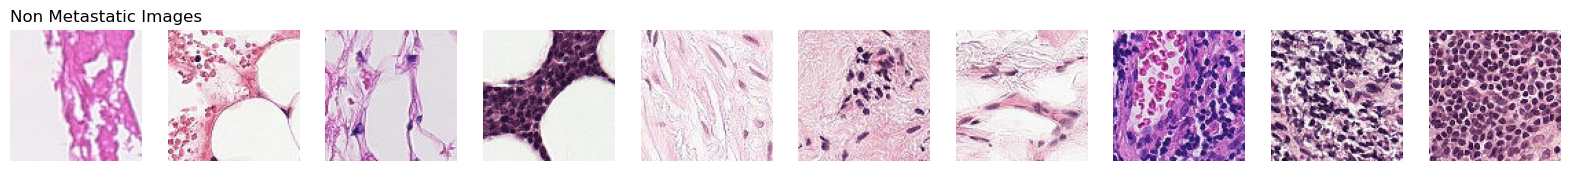

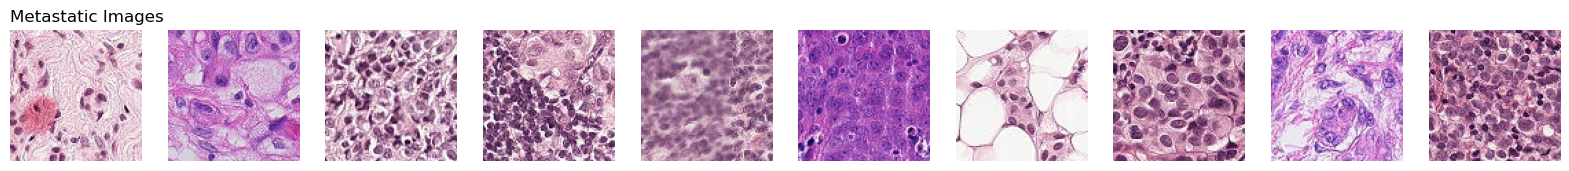

In [7]:
# Plot images of the metastatic and non metatstatic 
n = 10
# Take n random samples from each class 
img_non_metastatic_idx = np.random.choice(train_labels.loc[train_labels['label']==0,'id'].index,n,replace=False)
img_non_metastatic = (train_labels.loc[img_non_metastatic_idx,'id']+r'.tif').tolist()

img_metastatic_idx = np.random.choice(train_labels.loc[train_labels['label']==1,'id'].index,n,replace=False)
img_metastatic = (train_labels.loc[img_metastatic_idx,'id']+r'.tif').tolist()

plot_images(img_non_metastatic,'Non Metastatic Images')
plot_images(img_metastatic,'Metastatic Images')

Between the metastatic and non metastatic images, it is hard to differentiate the difference between the sets of images though. Though what we do notice is that rotation or flips in the images should still belong to the same class.

Count of No Cancer Detected: 130,908
Count of Cancer Detected: 89,117
Total samples: 220,025


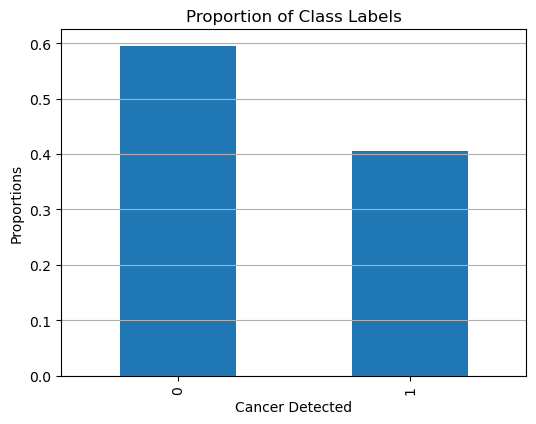

In [10]:
# Look at the class balancing 
class_prop = train_labels['label'].value_counts()
print(f'Count of No Cancer Detected: {class_prop.loc[0]:,}')
print(f'Count of Cancer Detected: {class_prop.loc[1]:,}')
print(f'Total samples: {class_prop.sum():,}')

# Get the Percentage 
class_prop = class_prop.div(class_prop.sum())

# Add visualization (percentage bar chart)
class_prop_fig = plt.figure(figsize=(6,4.5))
ax = plt.gca()
class_prop.plot(kind='bar',ax=ax)

plt.grid(which='Major',axis='y')

plt.title('Proportion of Class Labels')
plt.ylabel('Proportions')
plt.xlabel('Cancer Detected')

plt.show();

There's roughly a 60/40 ratio between non-metastatic cancer and metastatic cancer. We can look into applying some balancing, but given the discrepancy between class is not large and our assessment on our model will be based on the AUC in the ROC curve, we will choose to not balance the classes for now.

#### Summary of EDA

* Class imbalance is around 60/40 for non metastatic vs metastatic cases respectively. Given the difference is not large, we will opt to not use class balancing techniques for now
* No duplicate images found and every labeled image has an associated image, so no null values. 
* Rotations and flips of an image should still belong to the same class. We can increase our data pool by rotating and flipping our images 
* Because the primary image is captured in the 32x32 center portion of our images, we can reduce the amount of computation by reducing the size of our images to focus on just that portion. But in practice, we will not know exactly where to look on an image and so will train the model on the whole 96x96 image. 

#### Preprocessing

In [6]:
# GLOBAL TRAIN VARIABLES
# TARGET_SIZE = (BATCH_SIZE,96,96,3)
TARGET_SIZE = (96,96)
BATCH_SIZE = 32
MAX_EPOCH = 10

In [7]:
# First we adjust the train_labels file 
train_labels['filename'] = train_labels['id'] + '.tif'
train_labels['label'] = train_labels['label'].astype(str)

with tf.device("/CPU:0"):
    img_gen = ImageDataGenerator(
        rescale = 1.0/255.0,
        validation_split=0.2
    )
    n = 10_000
    train_gen = img_gen.flow_from_dataframe(
        train_labels,
        directory=TRAIN_DIRECTORY,
        x_col='filename',
        y_col='label',
        class_mode='binary',
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=1001,
        subset='training',
        featurewise_center = True, # Ideally can set this
        featurewise_std_normalization=True # Ideally can set this
    )
    valid_gen = img_gen.flow_from_dataframe(
        train_labels,
        directory=TRAIN_DIRECTORY,
        x_col='filename',
        y_col='label',
        class_mode='binary',   
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=1001,
        subset='validation',
        featurewise_center = True, # Ideally can set this
        featurewise_std_normalization=True # Ideally can set this        
    )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Model Architecture

### Base Model

For our base model we will be using a 2-hidden layer architecture convolutional neural network model. CNN has shown lots of success with image recognition. Reason to pick two layers to start is because many currently very successful models found success with this structure, typically with two convolutional layers and a max pooling layer. As well we will be adding a normalization layer after every convolutional layer as this should help prevent some overfitting. We can increase the complexity of the model, that is increase the number of layers, but this comes at the cost of overfitting ans so we will settle with this model to start. 

As for the other hyperparameters we use the below with explanation for each.

* Filter Size: (3x3). Using a 3x3 filter we can replicate larger dimension filters through iterative use of 3x3 with less computation.
* Learning rate: 1e-3. We use the default learning rate and will then reexamine based on the results
* Optimizer: Adam. We start with Adam optimizer as it is quicker. Downside is it is likely to get caught in a local minimum on the loss function.
* Activation: We will be using RELU activation as a start. The depth of the network is quite short as a start but if we grow the network, the RELU will help prevent the vanishing/exploding gradient issue.
* Stride: We will use the default stride. We can decrease the complexity and computation cost of training by increasing this, but will evaluate after the initial results. 

In [38]:
def create_model(load_weights=False,weight_path='model_00.h5'):
        
    # Base Model 
    learning_rate = 1e-3
    input_dim = (96,96,3)
    kernel_size = (3,3)
    pool_size = (2,2)
    metrics = [AUC(name='auc'), BinaryAccuracy(name='accuracy')]
    max_epoch = 10

    model_00 = Sequential()

    # Layers
    model_00.add(
        Conv2D(
            filters=16,
            kernel_size=(3,3),
            input_shape=input_dim,
            activation='relu'
        )
    )
    model_00.add(BatchNormalization())
    model_00.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu'
        )
    )
    model_00.add(BatchNormalization())    
    
    model_00.add(Flatten())
    model_00.add(Dense(1,activation='sigmoid'))

    model_00.compile(
        optimizer=Adam(learning_rate), 
        loss = "binary_crossentropy", 
        metrics=metrics
    )

    # Print out the model
    model_00.summary()
    
    if load_weights:
        model_00.load_weights(weight_path)  
    
    return model_00


# Create and get weights for model
load_weights = False 
weight_path = '/kaggle/input/weights/model_00.h5'

model_00 = create_model(load_weights,weight_path)
with tf.device('/GPU:0'):    
    model_00_fit = model_00.fit(
        train_gen,
        epochs=MAX_EPOCH,
        batch_size=BATCH_SIZE,
        validation_data=valid_gen,
        workers=8
    )

# Save the weights manually to prevent accidental overrides 
# model_00.save_weights('./model_00.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 batch_normalization_6 (Batc  (None, 94, 94, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 92, 92, 32)        4640      
                                                                 
 batch_normalization_7 (Batc  (None, 92, 92, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 270848)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [10]:
def plot_metrics(history,metric,title=None,val_plot=True): 
    fig,axs = plt.subplots(1,1,figsize=(5,3))
    
    # Plot Loss
    axs.plot(
        range(len(history[metric])),
        history[metric],
        label='training',
        color = 'black'
    )
    if val_plot:
        axs.plot(
            range(len(history[metric])),
            history[f'val_{metric}'],
            label='validation',
            color='red'
        )
    
    # Aesthetics
    axs.legend()
    axs.grid(axis='y')
    axs.set_title(title)
    axs.set_xlabel('epoch')
    
    plt.show()

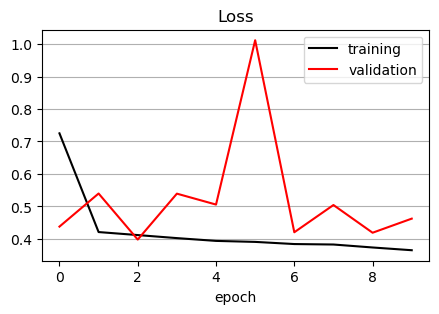

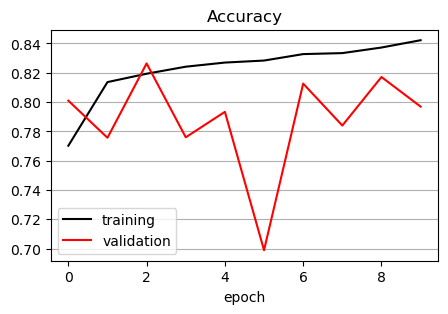

In [40]:
# Metrics 
plot_metrics(model_00_fit.history,'loss', 'Loss')
plot_metrics(model_00_fit.history,'accuracy','Accuracy')

From the above charts, note the follwing: 
* The validation loss jump around and is almost consistently higher than the training set
* The training accuracy continues to increase as we increase our epoch but our validation accuracy jumps around about 10% less than the training set
* The training set accuracy continues to improve with epoch and does not appear to have converged.

The poorer performance in the validation set indicates we may have some overfitting in our training as the validation set shows almost consistenly weaker performance to the training set.

The improvement in the accuracy and loss in our training set as we increase epochs indicates that we may not have found convergence and that using more epochs or increasing our learning rate may be beneficial. 

To help reduce the overfitting of our model, we will first try to adjust the learning rate. Smmith (2017) proposed a cyclical learning rate procedure to try and get the optimal learning rate by change the learning rate withing an interval of acceptable learning over the training of the model. This method allows us to train the model using multiple learning while only having to train the model once, hence saving lots on computation. 

In [8]:
def create_learner_model():
        
    # Base Model 
    learning_rate = 1e-4
    input_dim = (96,96,3)
    kernel_size = (3,3)
    pool_size = (2,2)
    metrics = [AUC(name='auc'), BinaryAccuracy(name='accuracy')]
    max_epoch = 12

    model = Sequential()

    # Layers
    model.add(
        Conv2D(
            filters=16,
            kernel_size=(3,3),
            input_shape=input_dim,
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=input_dim,
            activation='relu'
        )
    )
    model.add(BatchNormalization())    
    
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    
    # Cyclical Learning rate
    steps_per_epoch = train_labels.shape[0]//BATCH_SIZE
    clr = tfa.optimizers.CyclicalLearningRate(
        initial_learning_rate = learning_rate,
        maximal_learning_rate = learning_rate*100,
        scale_fn = lambda x: 1/(2.**(x-1)),
        step_size = 2 * steps_per_epoch
    )
    
    model.compile(
        optimizer=Adam(clr), 
        loss = "binary_crossentropy", 
        metrics=metrics
    )

    # Print out the model
    model.summary()
    
    return model

# Can we use more a more assess how big of a learner rate we need
model_learner = create_learner_model()
with tf.device('/GPU:0'):
    model_learner_fit = model_learner.fit(
        train_gen,
        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCH
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 92, 92, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 270848)            0         
                                                                 
 dense (Dense)               (None, 1)                 2

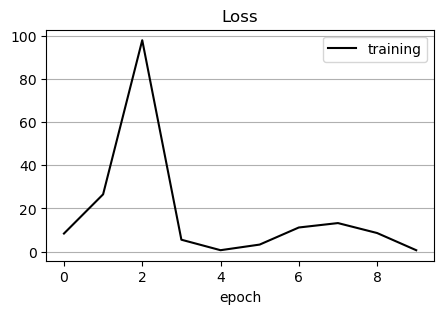

In [11]:
plot_metrics(model_learner_fit.history,'loss', 'Loss',val_plot=False)

Chart above shows at that the learning rate we used at the 4th epoch has the lowest loss.

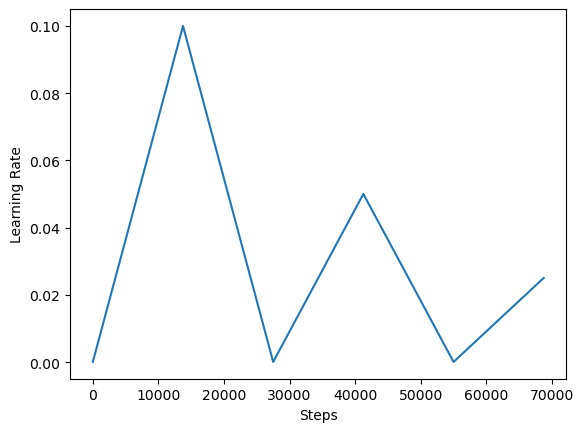

In [19]:
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = 1e-4,
    maximal_learning_rate = learning_rate*100,
    scale_fn = lambda x: 1/(2.**(x-1)),
    step_size = 2 * steps_per_epoch
)

step = np.arange(0, MAX_EPOCH * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Above shows the Learning Rate Cycle used at each step

In [36]:
# Find the learning rate at the 4th epoch
learning_rate = 1e-4
steps_per_epoch = train_labels.shape[0]//BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = learning_rate,
    maximal_learning_rate = learning_rate*100,
    scale_fn = lambda x: 1/(2.**(x-1)),
    step_size = 2 * steps_per_epoch
)
step = np.arange(0, MAX_EPOCH * steps_per_epoch)
lr_4 = clr(step)[steps_per_epoch*4]
print(f'Learning Rate at epoch 4: {lr_4:0.01}')

Learning Rate at epoch 4: 0.0001


From the above we can see the optimal learning rate is at the 4th epoch which corresponds to a learning rate of 0.0001, about 10 times lower than our initial learning rate.

To help combat the low score on the validation set, we could either change our model structure, change our learning rate, or even potentially adjust our data preprocessing. 

In [10]:
def create_model_01(load_weights=False,weight_path='model_01.h5'):
        
    # Base Model 
    learning_rate = 1e-4
    input_dim = (96,96,3)
    kernel_size = (3,3)
    pool_size = (2,2)
    metrics = [AUC(name='auc'), BinaryAccuracy(name='accuracy')]
    
    model = Sequential()

    # Layer 1
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=input_dim,
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(Activation(relu))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # Layer 2
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(Activation(relu))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # Layer 3
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            input_shape=input_dim,
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(Activation(relu))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # Layer 4
    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            input_shape=input_dim,
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(Activation(relu))
    model.add(MaxPooling2D(pool_size=pool_size))   
    
    # Layer 4
    model.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            input_shape=input_dim,
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(Activation(relu))
    model.add(MaxPooling2D(pool_size=pool_size))       
    
    # Full connected
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate), 
        loss = "binary_crossentropy", 
        metrics=metrics
    )

    # Print out the model
    model.summary()
    
    if load_weights:
        model.load_weights(weight_path)  
    
    return model

model_01 = create_model_01()
max_epoch = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
with tf.device('/GPU:0'):    
    model_01_fit = model_01.fit(
        train_gen,
        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCH,
        validation_data=valid_gen,
        workers=8,
        callbacks=[callback]
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

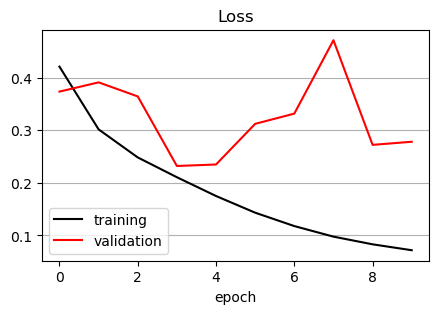

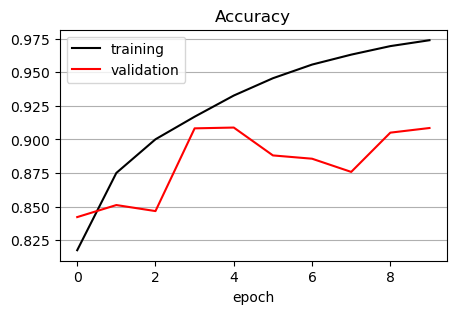

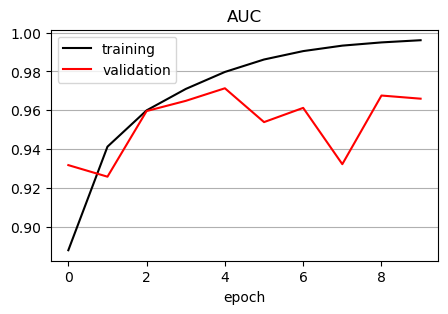

In [34]:
# Metrics 
plot_metrics(model_01_fit.history,'loss', 'Loss')
plot_metrics(model_01_fit.history,'accuracy','Accuracy')
plot_metrics(model_01_fit.history,'auc','AUC')

We are going to try one more model, the Dense Net 201 model which is a 201 layer network. The model's advantage is its ability to deal with vanishing gradient through the use of having each layer use preceding layers as inputs. With the large network and this method, this will allow for a more complex model to be captured combined with more training efficiency. 

In [25]:
# Testing prebuilt models 
def dense_net_201():
    inp = Input((96,96,3))
    g = DenseNet201()(inp)
    g = Dropout(0.5)(g)
    g = Dense(1,activation='sigmoid')(g)
    return Model(inputs = inp,outputs=g)

model_dense = dense_net_201()
model_dense.compile(
    optimizer=Adam(1e-3), 
    loss = "binary_crossentropy", 
    metrics=['accuracy']
)
max_epoch = 10
with tf.device('/GPU:0'):    
    model_dense_fit = model_dense.fit(
        train_gen,
        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCH,
        validation_data=valid_gen,
        workers=8
    )

Epoch 1/10
5501/5501 [==============================] - 1015s 162ms/step - loss: 0.5179 - accuracy: 0.7466 - val_loss: 0.4156 - val_accuracy: 0.8286
Epoch 2/10
5501/5501 [==============================] - 851s 155ms/step - loss: 0.3951 - accuracy: 0.8379 - val_loss: 0.3163 - val_accuracy: 0.8660
Epoch 3/10
5501/5501 [==============================] - 858s 156ms/step - loss: 0.3504 - accuracy: 0.8619 - val_loss: 0.2629 - val_accuracy: 0.8976
Epoch 4/10
5501/5501 [==============================] - 854s 155ms/step - loss: 0.2827 - accuracy: 0.8956 - val_loss: 0.2272 - val_accuracy: 0.9121
Epoch 5/10
5501/5501 [==============================] - 847s 154ms/step - loss: 0.2318 - accuracy: 0.9161 - val_loss: 0.3563 - val_accuracy: 0.8489
Epoch 6/10
5501/5501 [==============================] - 834s 151ms/step - loss: 0.2602 - accuracy: 0.9103 - val_loss: 0.2301 - val_accuracy: 0.9125
Epoch 7/10
5501/5501 [==============================] - 874s 159ms/step - loss: 0.2253 - accuracy: 0.9131 - val

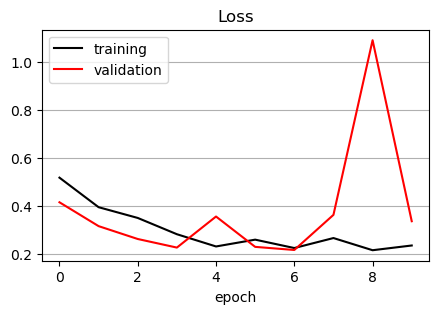

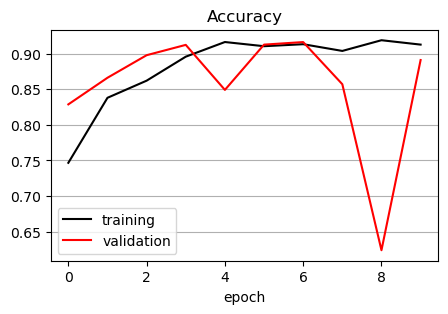

In [37]:
# Metrics 
plot_metrics(model_dense_fit.history,'loss', 'Loss')
plot_metrics(model_dense_fit.history,'accuracy','Accuracy')

Interestingly enough with the more complicated network, we do not see a substantial increase in the accuracy or reduction in the loss. As a matter of fact the reduction in loss is much greater for our second model. Hence based on these results we are going to be opting to use our second model for our final submission.

In [26]:
# Creating Generator for test
img_gen_test = ImageDataGenerator(rescale=1.0/255.0)
test_gen = img_gen_test.flow_from_dataframe(
    test,
    directory=TEST_DIRECTORY,
    x_col='filename',
    class_mode=None,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    featurewise_center = True, # Ideally can set this
    featurewise_std_normalization=True # Ideally can set this        
)

Found 57458 validated image filenames.


In [27]:
with tf.device('/GPU:0'):
    predictions = model_01.predict(test_gen)

test['label'] = predictions.round()
test[['id','label']].to_csv('submission.csv',index=False)

1796/1796 [==============================] - 290s 162ms/step


# Results and Analysis

From our initial model we can see that the general tip of starting with a network of two convolutions and final pooling layer strong performance from the start. Our initial model looked quite promising with AUC score above 0.8 for both the training and validation set. As well accuracy for the training set was promising being above 80% but the validation set being only above 70% indicating we overfitting of the model. 

In order to combat over fitting, using Cyclical Rate Policy developed by Smith (2017) we were able to have more confidence our initial learning rate was closer to the optimal (not necessarily optimal) learning rate. The use of Adam optimizer takes a moving average of learning rates and so we are not able to get the exact number from looking at our loss plot. Although we could continue with brute force methods or other custom learning rate to discover the most optimal, this comes at the computational cost, but could be explored in the future.

Our second model showed great improvements with higher accuracy and lower loss for both the training and validation set. This came from a combination of the lower learning rate we found from using the Cyclical Rate Policy and the increased in layers to capture more complicated relationships as needed. Although this lead to more overfitting as indicated by the much better score in the training set than the validation set, we reduced this with the addition of a Dropout layer at the end. 

# Conclusion 

We were able to produce a result of 0.5 AUC score for the test set. This indicates that there are much more improvements that are still needed for the model.

On the data front, we could also look at reducing the focus of the images potentially cropping the image to only the centre 32x32 pixels.

For further analysis, we could look into making a more complex model to better reduce the overfit of the model using larger strides or even adding in regularization into the model, or even more dropout layers.


# References

* Ioffe, Sergey. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. 2015.https://arxiv.org/pdf/1502.03167.pdf
* Smith, Leslie. Cyclical Learning Rates for Training Neural Networks. 2017. https://arxiv.org/pdf/1506.01186.pdf